# DM873 / DS809 project - dogs and cats classifier (F2020)

Balázs András Tolnai (batol20@student.sdu.dk) (DM873) \
Christian Tim Michael Goldapp (chgol20@student.sdu.dk) (DM873) \
Christian Skjerning (cskje16@student.sdu.dḱ) (DS809)

Task 1: Balázs, C. Skjerning \
Task 2: Balázs, C. Skjerning \
Task 3: Balázs \
Task 4: C. Goldapp

In [1]:
!pip install keras h5py ipyplot
%matplotlib inline
#%load_ext tensorboard

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import os, datetime, shutil
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator, load_img, img_to_array
from tensorflow import keras
from keras import layers

from tensorboard import notebook
from IPython.core.display import Image, display
import ipyplot

import matplotlib.pyplot as plt

from tensorboard.plugins.custom_scalar import layout_pb2
from tensorboard.summary.v1 import custom_scalar_pb

print (f'TF version: {tf.__version__}')

TF version: 2.3.1


In [4]:
DATASET_ROOT = 'dataset'
CLASSES = ['cat', 'dog']
DATA_DIR = os.path.join(DATASET_ROOT, 'dataset')
FULL_DATA_DIR = os.path.join(DATASET_ROOT, 'full_dataset')
TRAIN_DATA_DIR = os.path.join(DATASET_ROOT, 'train')
VAL_DATA_DIR = os.path.join(DATASET_ROOT, 'validation')
TEST_DATA_DIR = os.path.join(DATASET_ROOT, 'test')

## Construct datasets
1. Fetch list of all images in dataset
2. Split the list into the two classes: cats and dogs
3. Split each class into training, validation and testing subdatasets
4. Copy the original images/blobs into the new directories

In [5]:
def copy_file(origin, dest):
    # Make sure directory exists while copying
    dest_dir = os.path.dirname(os.path.abspath(dest))
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    shutil.copyfile(origin, dest)

def construct_datasets(val_ratio, test_ratio):
    
    # Remove any existing directories
    for _dir in [TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR, FULL_DATA_DIR]:
        if os.path.exists(_dir):
            shutil.rmtree(_dir)
    
    files = os.listdir(DATA_DIR)
    np.random.shuffle(files)
    
    subsets = list()
    for _class in CLASSES:
        subsets.append(list(filter(lambda img_name: _class in img_name, files)))
                       
    for _class, subset in zip(CLASSES, subsets):
        for f in subset:
            from_path = os.path.join(DATA_DIR, f)
            to_path   = os.path.join(FULL_DATA_DIR, f'{_class}s', f)
            copy_file(from_path, to_path)
        
        train, val, test = np.split(subset, [int(len(subset)* (1 - (val_ratio + test_ratio))), int(len(subset)* (1 - test_ratio))])
        
        for _subset, _dir in zip([train, val, test], [TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR]):
            # Copy files to their respective subset directories (train, validation and test)
            for f in _subset:
                from_path = os.path.join(DATA_DIR, f)
                to_path   = os.path.join(_dir, f'{_class}s', f)
                copy_file(from_path, to_path)

# Split dataset into chunks whereof 80% is training, 15% is validation and 5% is test
construct_datasets(val_ratio=0.15, test_ratio=0.05)

In [6]:
# Inspect dataset

for _class in CLASSES:
    train = os.listdir(os.path.join(TRAIN_DATA_DIR, f'{_class}s'))
    val   = os.listdir(os.path.join(VAL_DATA_DIR, f'{_class}s'))
    test  = os.listdir(os.path.join(TEST_DATA_DIR, f'{_class}s'))
    print(f'Class "{_class}" has {len(train)} training, {len(val)} validation and {len(test)} samples')
    
    print(f'Images from "{_class}" training set')
    train_images = [os.path.join(TRAIN_DATA_DIR, f'{_class}s', train[i]) for i in range(5)]
    ipyplot.plot_images(train_images, img_width=160)
    
    print(f'Images from "{_class}" validation set')
    val_images = [os.path.join(VAL_DATA_DIR, f'{_class}s', val[i]) for i in range(5)]
    ipyplot.plot_images(val_images, img_width=160)
    
    print(f'Images from "{_class}" test set')
    test_images = [os.path.join(TEST_DATA_DIR, f'{_class}s', test[i]) for i in range(5)]
    ipyplot.plot_images(test_images, img_width=160)

Class "cat" has 1200 training, 225 validation and 75 samples
Images from "cat" training set


Images from "cat" validation set


Images from "cat" test set


Class "dog" has 1200 training, 225 validation and 75 samples
Images from "dog" training set


Images from "dog" validation set


Images from "dog" test set


# Extend dataset using augmentation

In [7]:
#we use a quite large patience for early stopping, because we have a lot of fluctuation.
patience = 50
imageSizeX = 150
imageSizeY = 150
batchSize = 32

In [8]:
def extended_datasets():
    
    
    # Training set
    train_gen = ImageDataGenerator(
        rescale=1/255. ,
        rotation_range=0,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
    )
    train = train_gen.flow_from_directory(
        directory=TRAIN_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    # Validation set
    validation = ImageDataGenerator(
        rescale=1./255
    ).flow_from_directory(
        directory=VAL_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary',
    )
    
    # Testing set
    test_gen = ImageDataGenerator(rescale=1./255)
    test = DirectoryIterator(
        directory=TEST_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary',
        image_data_generator=test_gen
    )
    
    # All data
    all_data = train_gen.flow_from_directory(
        directory=FULL_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    return train, validation, test, all_data

train_data, val_data, test_data, all_data = extended_datasets()

Found 2400 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.



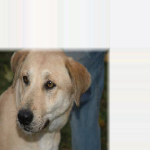
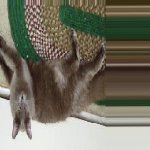


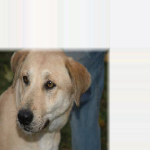
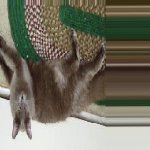


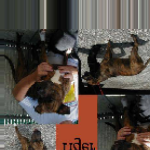
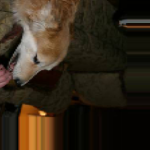


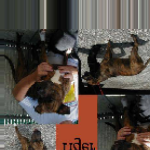
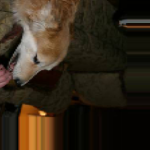


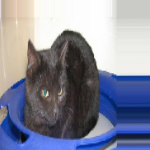
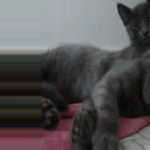


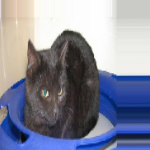
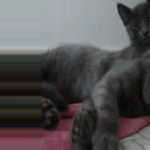


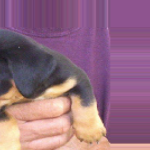
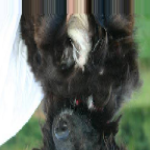


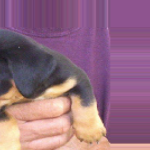
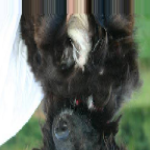


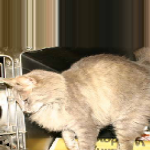
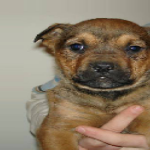


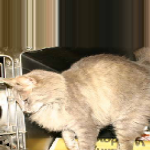
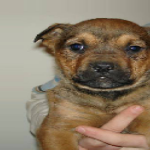

In [9]:
# Inspect augmentation

inspect_data = train_data

for _ in range(5):
    batch = inspect_data.next()
    images = batch[0]
    labels = [CLASSES[int(batch[1][i])] for i in range(len(batch))]
    ipyplot.plot_images(images, labels, img_width=150)


# Create model

We tried to create a vgg16 type network, where the filter size, and the number of convolution layers increases
while the pooling layers decreese the feature maps' size.
the pooling layer sizes were selected as 2, 3, 5
with the idea of reducing the featuremap sizes from 150 to 75, to 25 and then to 5
finally a global pooling, (in this case equal to an other pooling layer of size 5)

BatchNormalization layers should make the learning prcess faster, and reduce
the amount on noise learned by lowering the mean activation and activation standard deviation

we used dropout layers to reduce overfitting

In [10]:
def create_model():
    model = keras.Sequential([

        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(imageSizeX, imageSizeY, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),
        layers.Dropout(0.4),


        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(3,3),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(5,5),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.4),


        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),    

        layers.Dense(1, activation ='sigmoid')
    ])
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
        
    return model

In [11]:
# stops the training at given training accuracy
class myCallback(keras.callbacks.Callback):
    targetAccuracy = 0.9
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > (self.targetAccuracy)):   
            self.model.stop_training = True

# Train model

In [12]:
def train_model(train_data, val_data, all_data):
    global patience

    model = create_model()

    # Training callbacks
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    checkpoint_filepath='training_checkpoints'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    cb = keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
    )
    
    training_history = model.fit(
        train_data,
        epochs=1000, #we stop training the model with early stopping
        validation_data=val_data,
        callbacks=[cb, tensorboard_callback]
    )
    
    
    # after the training on the training dataset is done, we attempt to learn on the validation data + training data
    # until we reach the same training accuracy as we did on the training data
    cb = myCallback()
    cb.targetAccuracy = training_history.history['accuracy'][-(patience+1)]
    training_history = model.fit(
        all_data,
        epochs=1000,
        callbacks=[cb, tensorboard_callback]
    )
    
    model.save(f'cats-dogs-model-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')
    return (model, training_history)


In [12]:
model, hist = train_model(train_data, val_data, all_data)

Epoch 1/1000
 1/75 [..............................] - ETA: 0s - loss: 0.7581 - accuracy: 0.5000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
75/75 [==============================] - 16s 211ms/step - loss: 0.8138 - accuracy: 0.5354 - val_loss: 0.7532 - val_accuracy: 0.5000
Epoch 2/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.7548 - accuracy: 0.5362 - val_loss: 0.8823 - val_accuracy: 0.5000
Epoch 3/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.7208 - accuracy: 0.5442 - val_loss: 0.6955 - val_accuracy: 0.5578
Epoch 4/1000
75/75 [==============================] - 16s 207ms/step - loss: 0.6899 - accuracy: 0.5742 - val_loss: 0.6815 - val_accuracy: 0.6044
Epoch 5/1000
75/75 [==============================] - 16s 20

Epoch 53/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.4745 - accuracy: 0.7833 - val_loss: 0.6212 - val_accuracy: 0.7067
Epoch 54/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.4831 - accuracy: 0.7812 - val_loss: 0.6611 - val_accuracy: 0.7956
Epoch 55/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.4765 - accuracy: 0.7879 - val_loss: 0.5509 - val_accuracy: 0.7578
Epoch 56/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.4609 - accuracy: 0.7821 - val_loss: 0.6821 - val_accuracy: 0.7511
Epoch 57/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.4756 - accuracy: 0.7796 - val_loss: 0.7201 - val_accuracy: 0.7756
Epoch 58/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.4792 - accuracy: 0.7833 - val_loss: 0.8870 - val_accuracy: 0.6711
Epoch 59/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.4939 - accuracy: 0.7629 - val_loss: 0.5186 -

75/75 [==============================] - 15s 204ms/step - loss: 0.3905 - accuracy: 0.8304 - val_loss: 0.4627 - val_accuracy: 0.8244
Epoch 110/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.3672 - accuracy: 0.8471 - val_loss: 0.3996 - val_accuracy: 0.8133
Epoch 111/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.3707 - accuracy: 0.8379 - val_loss: 0.3798 - val_accuracy: 0.8333
Epoch 112/1000
75/75 [==============================] - 15s 204ms/step - loss: 0.3775 - accuracy: 0.8383 - val_loss: 0.4503 - val_accuracy: 0.8533
Epoch 113/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.3760 - accuracy: 0.8413 - val_loss: 1.0020 - val_accuracy: 0.6889
Epoch 114/1000
75/75 [==============================] - 15s 207ms/step - loss: 0.3680 - accuracy: 0.8458 - val_loss: 0.4789 - val_accuracy: 0.8489
Epoch 115/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.3720 - accuracy: 0.8462 - val_loss: 0.5392 - val_acc

Epoch 165/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.3129 - accuracy: 0.8675 - val_loss: 0.2848 - val_accuracy: 0.8911
Epoch 166/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.3223 - accuracy: 0.8754 - val_loss: 0.4945 - val_accuracy: 0.8556
Epoch 167/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.3079 - accuracy: 0.8717 - val_loss: 0.3379 - val_accuracy: 0.8578
Epoch 168/1000
75/75 [==============================] - 15s 205ms/step - loss: 0.3276 - accuracy: 0.8658 - val_loss: 0.4227 - val_accuracy: 0.8422
Epoch 169/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.3406 - accuracy: 0.8737 - val_loss: 0.3770 - val_accuracy: 0.8556
Epoch 170/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.3124 - accuracy: 0.8717 - val_loss: 0.7849 - val_accuracy: 0.7556
Epoch 171/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.3233 - accuracy: 0.8675 - val_loss: 0

Epoch 221/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.2859 - accuracy: 0.8854 - val_loss: 0.4124 - val_accuracy: 0.8533
Epoch 222/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.2763 - accuracy: 0.8896 - val_loss: 0.5375 - val_accuracy: 0.8422
Epoch 223/1000
75/75 [==============================] - 15s 204ms/step - loss: 0.2479 - accuracy: 0.8971 - val_loss: 0.4376 - val_accuracy: 0.9067
Epoch 224/1000
75/75 [==============================] - 16s 207ms/step - loss: 0.2964 - accuracy: 0.8788 - val_loss: 0.3444 - val_accuracy: 0.8800
Epoch 225/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.2989 - accuracy: 0.8813 - val_loss: 0.3313 - val_accuracy: 0.9089
Epoch 226/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.2835 - accuracy: 0.8946 - val_loss: 0.3313 - val_accuracy: 0.8711
Epoch 227/1000
75/75 [==============================] - 15s 206ms/step - loss: 0.2769 - accuracy: 0.8921 - val_loss: 0

In [13]:
print("Average test loss: ", np.average(hist.history['loss']))

Average test loss:  0.2989189015193419


# Evaluation

In [32]:
loaded_model = keras.models.load_model('cats-dogs-model-20201115-180832.h5')

In [33]:
loaded_model.evaluate(test_data, verbose=1)

5/5 [==============================] - 0s 62ms/step - loss: 0.6646 - accuracy: 0.8600


[0.6645681858062744, 0.8600000143051147]

### Epoch accuracy graph
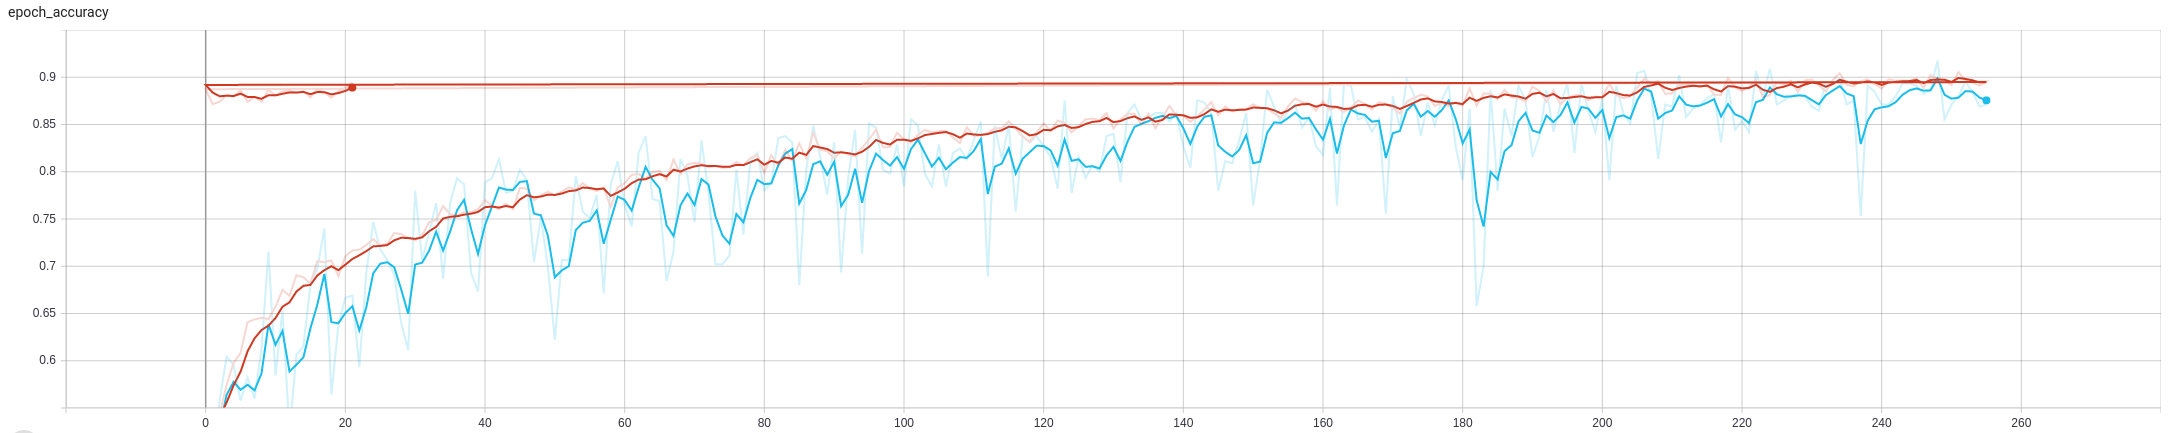

### Epoch loss graph
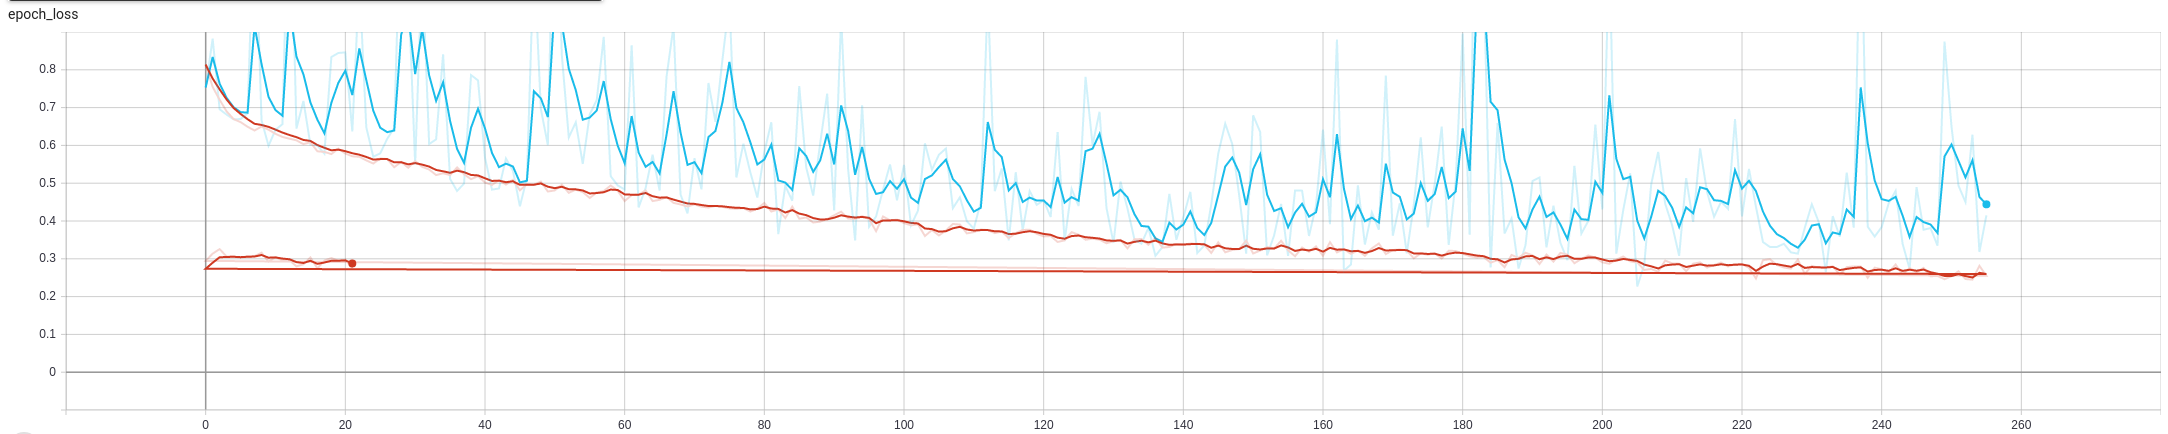


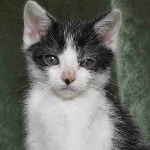
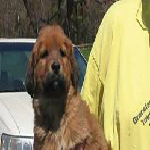
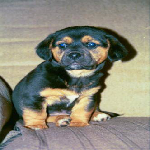
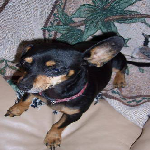
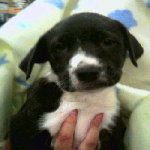
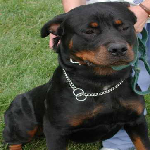
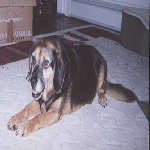
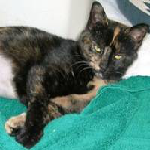
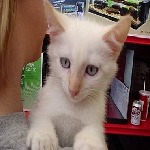
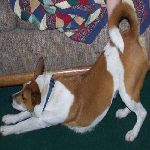
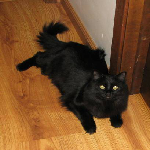
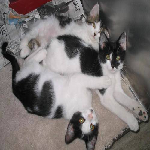
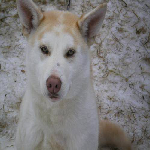
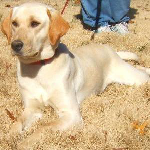
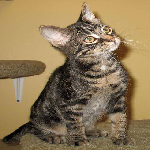
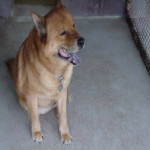
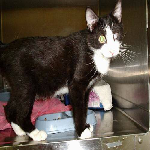
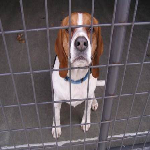
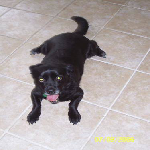
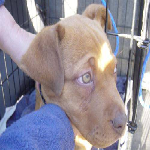
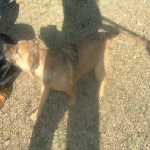
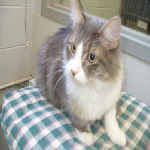


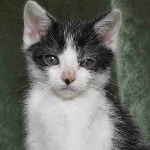
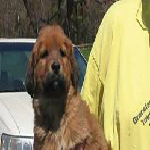
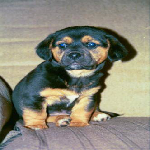
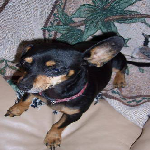
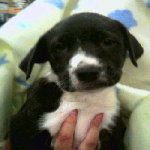
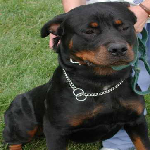
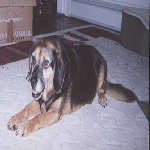
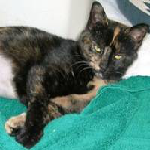
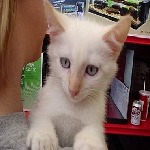
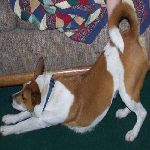
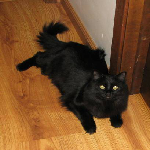
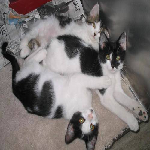
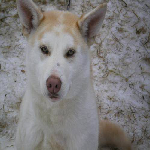
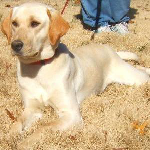
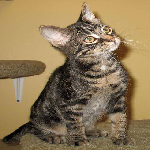
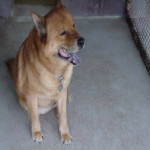
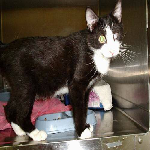
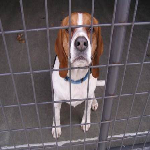
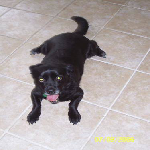
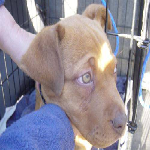
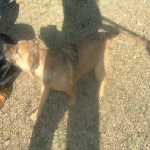
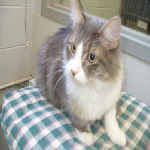

In [34]:
batch = test_data.next()

prediction_scores = loaded_model.predict_on_batch(batch[0])
squeezed_scores = np.squeeze(prediction_scores, axis=1)
max_imgs = 50
images = batch[0]
labels = [CLASSES[c] for c in batch[1].astype('int')]
scores = [s[0] if s[1] is 'dog' else 1.-s[0] for s in list(zip(squeezed_scores, labels))]
human_readable_scores = list(map(lambda score, label: f'{score*100:.2f}% {label}' , scores, labels))

ipyplot.plot_images(images[:max_imgs], human_readable_scores[:max_imgs], img_width=150)